# Proyecto: Análisis de mercado inmobiliario
## Erika Xenia Angenello

### 1. Introducción

El objetivo final de este proyecto será predecir el precio de venta de un inmueble, minimizando el error de dicha predicción. Para ello, partiremos de un conjunto de datos del mercado inmobiliario provisto por Properati, realizaremos un análisis exploratorio de los mismos y probaremos iteradamente distintos modelos de machine learning hasta obtener el mínimo error cuadrático medio con las herramientas estudiadas hasta el momento.

#### 1.2 Análisis temprano del problema
Antes de adentramos con el trabajo, realizaremos un análisis previo de aquellas variables que nos podrían ayudar a resolver el problema. 

Idealmente, si tuviésemos acceso ilimitado a la información que necesitamos, podríamos pensar que para enseñarle a nuestro modelo a predecir el valor de una propiedad, necesitamos contar con los mismos datos que observa un tasador/ra a la hora de valuar una propiedad en general:

* Ubicación. 
* Superficie cubierta y total.
* Cantidad de habitaciones.
* Cantidad de Baños.
* Antigüedad de la propiedad.
* Estado general de la propiedad.
* Calidad de los materiales de construcción.
* Cercanía respecto a puntos de interés como colegios, universidades y accesos. 
* Valor del terreno.

Asimismo, dependiendo del tipo de propiedad, seguramente podremos observar que otros factores también influyen en sus precio de mercado. A continuación algunos ejemplos:

* En el caso de una casa, si la misma cuenta con pileta, quincho, parrilla y garaje entre otros.
* Para un departamento, si el mismo cuenta con patio o balcón, su luminosidad, el piso en el que se encuentra ubicado, la vista y demás. En este caso, también se adicionan las condiciones generales del edificio como altas o bajas expensas, ascensores, amenities y seguridad.

Por último, si tenemos en cuenta la temporalidad de las instancias a observar, se sabe que, en países con alta inestabilidad cambiaria como Argentina, los períodos en que el peso argentino se deprecia respecto al dólar estadounidense, las propiedades sufren una disminución general de su precio de venta en el mercado y que dicho efecto es el inverso cuando el peso se revaloriza. 

### 2. Análisis Exploratorio de Datos

A continuación, exploraremos los datos con los que contamos para resolver el problema con el fin de obtener información relevante.

#### 2.1.1 Importación de datos: 

In [65]:
# Importamos las librerías principales para empezar a trabajar

import pandas as pd
import numpy as np

#Importo paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

#Doy formato a la visualización del dataframe
pd.options.display.float_format = '{:,.1f}'.format

In [40]:
# Importo el dataset
data = pd.read_csv(r'DS_Proyecto_01_Datos_Properati.csv')

# Visualizo las primeras 5 instancias
data.head(3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.6,-58.4,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,"153,000.0",USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.6,-58.4,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,"159,000.0",USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.6,-58.4,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,"125,000.0",USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


In [46]:
data.dtypes

start_date         datetime64[ns]
end_date                   object
created_on                 object
lat                       float64
lon                       float64
l1                         object
l2                         object
l3                         object
rooms                     float64
bedrooms                  float64
bathrooms                 float64
surface_total             float64
surface_covered           float64
price                     float64
currency                   object
title                      object
description                object
property_type              object
operation_type             object
dtype: object

In [3]:
data.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

Las variables que tenemos en nuestro set de datos responden a la siguiente información:


* **start_date** - Fecha de alta del aviso.
* **end_date** - Fecha de baja del aviso.
* **created_on** - Fecha de alta de la primera versión del aviso.
* **lat** - Latitud.
* **lon** - Longitud.
* **l1** - Nivel administrativo 1: país.
* **l2** - Nivel administrativo 2: provincia.
* **l3** - Nivel administrativo 3: ciudad.
* **rooms** - Cantidad de ambientes (útil en Argentina).
* **bedrooms** - Cantidad de dormitorios (útil en el resto de los países).
* **bathrooms** - Cantidad de baños.
* **surface_total** - Superficie total en m².
* **surface_covered** - Superficie cubierta en m².
* **price** - Precio publicado en el anuncio.
* **currency** - Moneda del precio publicado.
* **title** - Título del anuncio.
* **description** - Descripción del anuncio.
* **property_type** - Tipo de propiedad (Casa, Departamento, PH).
* **operation_type** - Tipo de operación (Venta, Alquiler).

In [4]:
# Reordeno las columnas para que la variable Precio quede al final, ya que es nuestro target
columns = ['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 
           'surface_total', 'surface_covered', 'currency', 'title', 'description', 'property_type','operation_type', 'price']
data = data[columns]

In [5]:
# Cantidad de filas, Cantidad de columnas
print('Instancias, Columnas:', data.shape)

Instancias, Columnas: (146660, 19)


#### 2.1.2 Valores Faltantes: 

In [6]:
a = data.isnull().sum(axis=0)
b = round(a/data.shape[0]*100,2)

missing_df = pd.DataFrame({'missing_vals' : a, 'missing_ratio' : b})

missing_df[missing_df['missing_vals']>0]

,missing_vals,missing_ratio
lat,9925,6.8
lon,9959,6.8
bathrooms,5957,4.1
surface_total,20527,14.0
surface_covered,21614,14.7


#### 2.1.3. Tipos de propiedad:

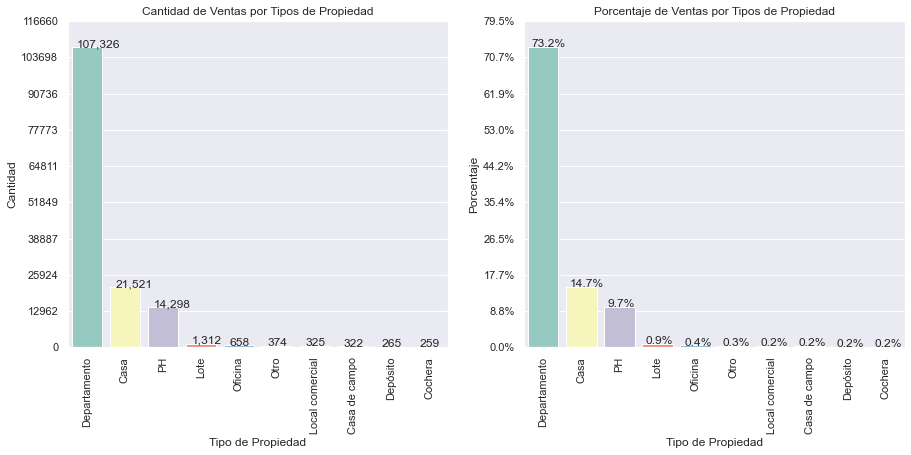

In [7]:
plt.rc("figure", figsize=(15, 6))

# Grafico

ncount= len(data)
plt.subplot(1, 2, 1)
ax = sns.countplot(data = data, x = 'property_type', order = data['property_type'].value_counts().index, orient="v", palette ='Set3')
plt.setp(ax.get_xticklabels(), rotation=90)

plt.title('Cantidad de Ventas por Tipos de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Cantidad')


for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
ax.yaxis.set_ticks(np.linspace(0, ncount-30000, 10))

# Grafico
    plt.subplot(1, 2, 2)

ncount = len(data)
ax1 = sns.countplot(data = data, x = 'property_type', order = data['property_type'].value_counts().index, orient="v", palette ='Set3')
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.title('Porcentaje de Ventas por Tipos de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Porcentaje')
 
for p in ax1.patches:
        ax1.annotate('{:.1f}%'.format(100*p.get_height()/ncount), (p.get_x()+0.1, p.get_height()+5))


ax1.yaxis.set_ticks(np.linspace(0, ncount-30000, 10))

_ =ax1.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/ncount))

#### Comentarios:
Se puede observar que sólo 3 tipos de propiedad (Departamento, Casa y PH) acumulan más del 96% de los datos. ] 

#### 2.1.4. Regiones de las publicaciones

Iniciaremos representando gráficamente la distribución de las ventas por región

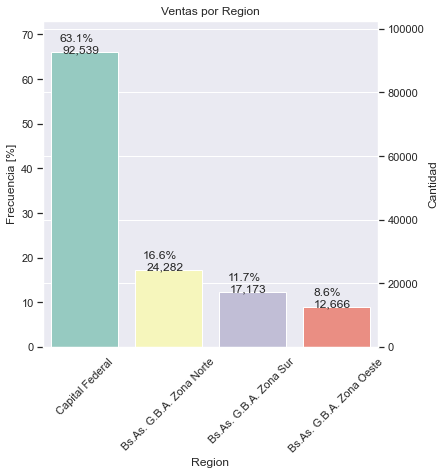

In [8]:
ncount = len(data)

plt.figure(figsize=(6,6))

#Grafico
ax = sns.countplot(x='l2', data=data, order= data['l2'].value_counts().index, palette ='Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.title('Ventas por Region')
plt.xlabel('Region')
plt.ylabel('Cantidad')

# Eje gemelo
ax2=ax.twinx()

# Setar el eje del conteo a la derecha y el de la frecuencia a la izquierda
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Cambiar las etiquetas
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frecuencia [%]')

# Etiquetas frecuencia absoluta
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.135, p.get_height()))

#Etiqutas frecuencia relativa
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean()-0.1, y+3000), ha='center', va='bottom') 


# Fijar el rango de frecuencia a 0-100
ax2.set_ylim(0,(data['l2'].value_counts()[0]/ncount*100)+10)
ax.set_ylim(0,data['l2'].value_counts()[0]+10000)


# Apagar la cuadrícula en ax2 para que las líneas de cuadrícula no terminan en la parte superior de las barras
ax2.grid(None)

Se puede observar que más de la mitad de las ventas están concentradas en Capital Federal.

Para ampliar el análisis, haremos drill down sobre las ventas por barrio en cada una de las regiones:

In [9]:
#Preparo los datos

N_TOP = 10

# Preparo los datos para graficar

# Cuento la cantidad de ventas por Zona y por Barrio
count = data.groupby(['l2','l3'], as_index=False)['l1'].count()

# Me quedo con los primeros 10 barrios en ventas por Zona
count_max = count.sort_values(['l2', 'l1'], ascending=False).groupby('l2').head(N_TOP)

# Renombro
count_max = count_max.rename(columns = {'l1': 'Total'}, inplace = False)

# Joineo con la data original para quedarme sólo con los barrios que están en el top
data_grap = data.merge(count_max, how='left', on=['l2','l3'])

#Reemplazo nuelos por 0
data_grap = data_grap.fillna(0)

# Reemplazo por OTROS para graficar
data_grap['l3']= np.where(data_grap['Total'] == 0,'OTROS', data_grap['l3'])

#data_grap[data_grap['l2']=='Capital Federal']['l3'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS')

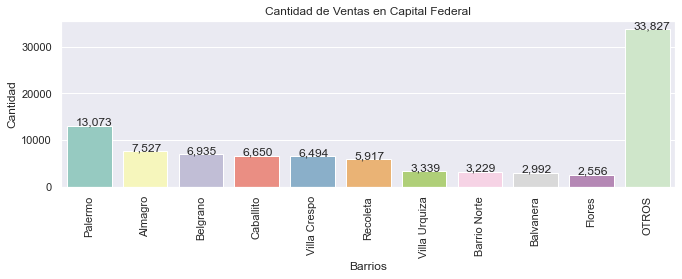

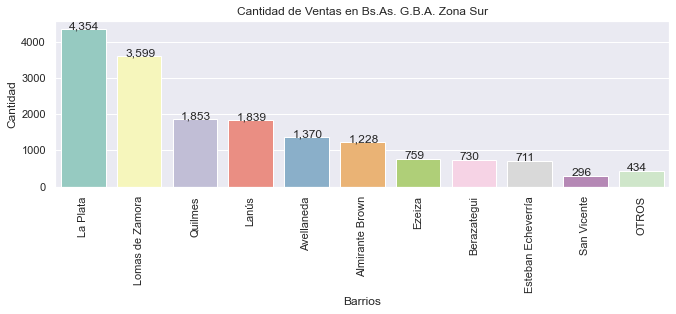

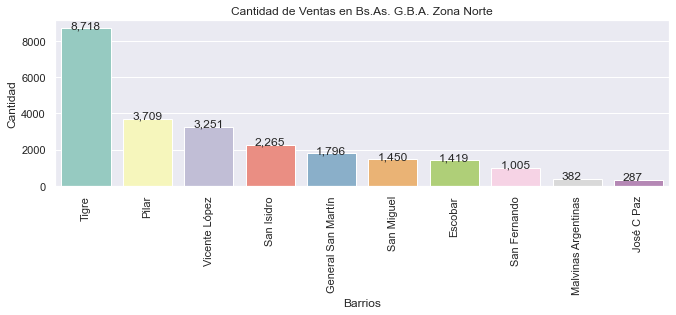

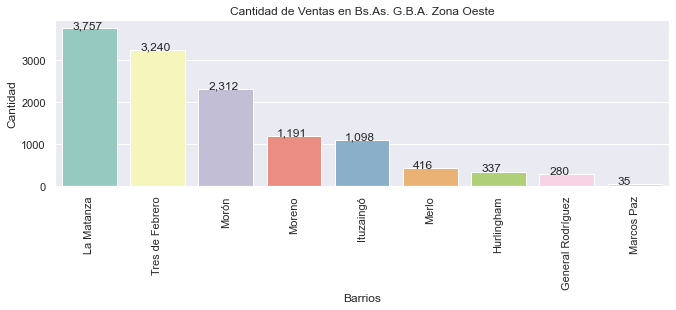

In [10]:
# Grafico

# Capital Federal
plt.figure(figsize=(11,14))
plt.subplot(4, 1, 1)

g1 = sns.countplot(data = data_grap[data_grap['l2']=='Capital Federal'], x='l3', 
                   order = data_grap[data_grap['l2']=='Capital Federal']['l3'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g1.get_xticklabels(), rotation=90)

plt.title('Cantidad de Ventas en Capital Federal')
plt.xlabel('Barrios')
plt.ylabel('Cantidad')

for p in g1.patches:
    g1.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

# Bs.As. G.B.A. Zona Sur
plt.figure(figsize=(11,14))
plt.subplot(4, 1, 2)

g2 = sns.countplot(data = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Sur'], x='l3', 
                   order = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Sur']['l3'].value_counts().index.drop('OTROS').insert(N_TOP+1, 'OTROS'), 
                   orient="v", palette ='Set3')
plt.setp(g2.get_xticklabels(), rotation=90)

plt.title('Cantidad de Ventas en Bs.As. G.B.A. Zona Sur')
plt.xlabel('Barrios')
plt.ylabel('Cantidad')

for p in g2.patches:
    g2.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
# Bs.As. G.B.A. Zona Norte
plt.figure(figsize=(11,14))
plt.subplot(4, 1, 2)

g3 = sns.countplot(data = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Norte'], x='l3', 
                   order = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Norte']['l3'].value_counts().index, 
                   orient="v", palette ='Set3')
plt.setp(g3.get_xticklabels(), rotation=90)

plt.title('Cantidad de Ventas en Bs.As. G.B.A. Zona Norte')
plt.xlabel('Barrios')
plt.ylabel('Cantidad')

for p in g3.patches:
    g3.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
    
# Bs.As. G.B.A. Zona Oeste
plt.figure(figsize=(11,14))
plt.subplot(4, 1, 2)

g4 = sns.countplot(data = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Oeste'], x='l3', 
                   order = data_grap[data_grap['l2']=='Bs.As. G.B.A. Zona Oeste']['l3'].value_counts().index, 
                   orient="v", palette ='Set3')
plt.setp(g4.get_xticklabels(), rotation=90)

plt.title('Cantidad de Ventas en Bs.As. G.B.A. Zona Oeste')
plt.xlabel('Barrios')
plt.ylabel('Cantidad')

for p in g4.patches:
    g4.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
#plt.savefig('snscounter.pdf')

#### 2.1.5. Filtrando el Dataset: 
Se seleccionarán las tres clases más abundantes de tipos de propiedad y la región con más propiedades publicadas. Luego, se creará un nuevo Data Frame con aquellas instancias que cumplen con esas condiciones.

In [11]:
# Filtramos los 3 tipos de propiedad con más ventas y la región con más ventas

df_mayores_ventas = data[((data['property_type']==data['property_type'].unique()[:3][0])| 
                           (data['property_type']==data['property_type'].unique()[:3][1])|
                           (data['property_type']==data['property_type'].unique()[:3][2])) &
                          (data['l2']==data['l2'].unique()[:1][0])]

In [12]:
print('Cantidad de instancias clases más abundantes',df_mayores_ventas.shape[0])
print('Datos respecto del dataset incial:',round(df_mayores_ventas.shape[0]/data.shape[0]*100,2),'%')

Cantidad de instancias clases más abundantes 91485
Datos respecto del dataset incial: 62.38 %


Graficamos la distribución del nuevo Data Frame por Tipo de Propiedad

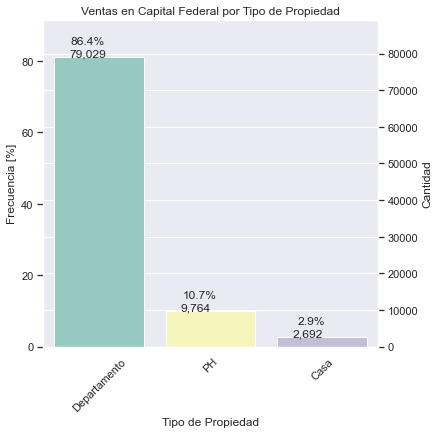

In [13]:
ncount = len(df_mayores_ventas)

plt.figure(figsize=(6,6))

# Grafico
ax = sns.countplot(x="property_type", data=df_mayores_ventas, order= df_mayores_ventas['property_type'].value_counts().index, palette ='Set3')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.title('Ventas en Capital Federal por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Cantidad')

# Eje gemelo
ax2=ax.twinx()

# Setar el eje del conteo a la derecha y el de la frecuencia a la izquierda
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Cambiar las etiquetas
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frecuencia [%]')

# Etiquetas frecuencia absoluta
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.135, p.get_height()))

# Etiqutas frecuencia relativa
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean()-0.1, y+3000), ha='center', va='bottom') # set the alignment of the text


# Fijar el rango de frecuencia a 0-100
ax2.set_ylim(0,(df_mayores_ventas['property_type'].value_counts()[0]/ncount*100)+5)
ax.set_ylim(0,df_mayores_ventas['property_type'].value_counts()[0]+10000)

# Apagar la cuadrícula en ax2 para que las líneas de cuadrícula no terminan en la parte superior de las barras
ax2.grid(None)

Se observa que casi el 80% de las ventas de Capital Federal corresponden a Departamentos

#### 2.1.6. Distribuciones y relaciones de a pares:

Se estudiará la distribución y las relaciones de a pares de las variables `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`, `price` para cada tipo de propiedad.

In [14]:
# Para que tenga más sentido el análisis, 
# nos quedaremos solo con los valores en que la superficie cubierta es menor a la total
df_mayores_ventas = df_mayores_ventas[df_mayores_ventas['surface_covered']<df_mayores_ventas['surface_total']]

<AxesSubplot:xlabel='price'>

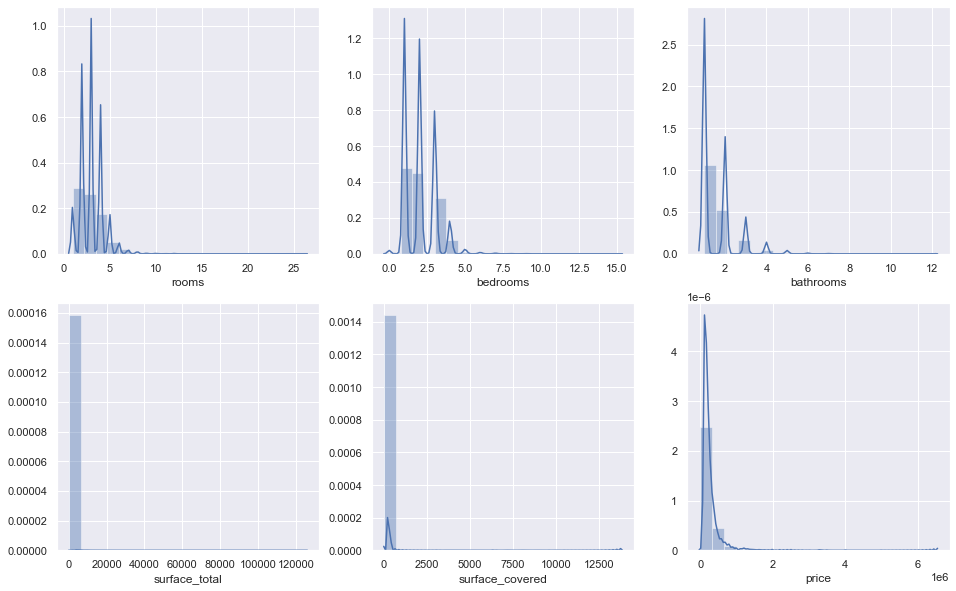

In [15]:
# Visualizamos la distribución de las variables 

plt.figure(figsize=(16,10))

plt.subplot(2, 3, 1)
sns.distplot(df_mayores_ventas['rooms'], bins = 20)

plt.subplot(2, 3, 2)
sns.distplot(df_mayores_ventas['bedrooms'], bins = 20)

plt.subplot(2, 3, 3)
sns.distplot(df_mayores_ventas['bathrooms'], bins = 20)

plt.subplot(2, 3, 4)
sns.distplot(df_mayores_ventas['surface_total'], bins = 20)

plt.subplot(2, 3, 5)
sns.distplot(df_mayores_ventas['surface_covered'], bins = 20)

plt.subplot(2, 3, 6)
sns.distplot(df_mayores_ventas['price'], bins = 20)


Se puede observar valores outliers en cada una de las variables, que hace difícil poder visualizar la verdadera distribución de las mismas.

Por ello, a continuación, se visualizarán los diagramas de caja y bigote de cada una de las variables agrupadas por unidad de medida.

In [16]:
# Agrupo las variables:
data_rooms = df_mayores_ventas[['rooms', 'bedrooms', 'bathrooms']]
data_sup = df_mayores_ventas[['surface_total', 'surface_covered']]
data_price = df_mayores_ventas[['price']]

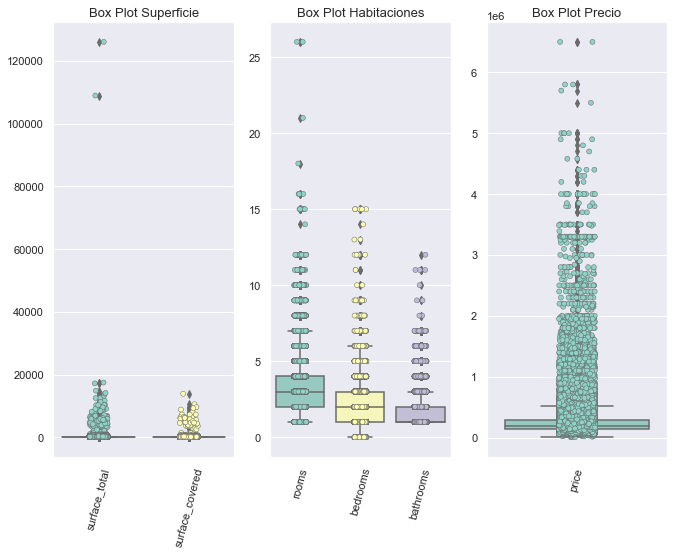

In [17]:
plt.rc("figure", figsize=(11, 8))

# Superficie
plt.subplot(1, 3, 1)
plt.title('Box Plot Superficie', fontsize = 13)

ax1 = sns.boxplot(data=data_sup, palette='Set3')
plt.setp(ax1.get_xticklabels(), rotation=75)
ax2 = sns.stripplot(data=data_sup,jitter=True, dodge=True, linewidth=0.5, palette='Set3')

# Habitaciones
plt.subplot(1, 3, 2)
plt.title('Box Plot Habitaciones', fontsize = 13)

ax3 = sns.boxplot(data=data_rooms, palette='Set3')
plt.setp(ax3.get_xticklabels(), rotation=75)
ax4 = sns.stripplot(data=data_rooms,jitter=True, dodge=True, linewidth=0.5, palette='Set3')

# Precio
plt.subplot(1, 3, 3)
plt.title('Box Plot Precio', fontsize = 13)

ax5 = sns.boxplot(data=data_price, palette='Set3')
plt.setp(ax5.get_xticklabels(), rotation=75)
ax6 = sns.stripplot(data=data_price, jitter=True, dodge=True, linewidth=0.5, palette='Set3')


Estudiando Superficie total

In [18]:
print('Min',df_mayores_ventas['surface_total'].min(), 'Max', df_mayores_ventas['surface_total'].max() )

Min 16.0 Max 126062.0


In [19]:
q25 = df_mayores_ventas['surface_total'].quantile(0.25) 
q75 = df_mayores_ventas['surface_total'].quantile(0.75)
iqr = q75 - q25
min_st = q25 - 1.5*iqr
max_st = q75 + 1.5*iqr

In [20]:
print(min_st, max_st)

-43.0 213.0


In [21]:
data_sin_out = df_mayores_ventas[(df_mayores_ventas['surface_total'] > min_st)&(df_mayores_ventas['surface_total'] < max_st)]

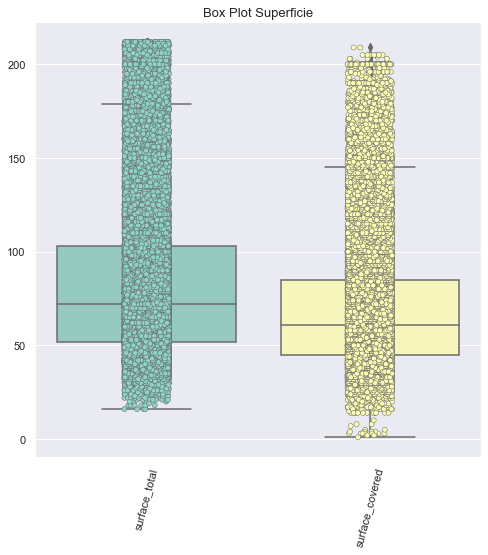

In [22]:
plt.rc("figure", figsize=(8, 8))

data_sin_out_sup = data_sin_out[['surface_total', 'surface_covered']]

plt.title('Box Plot Superficie', fontsize = 13)

ax1 = sns.boxplot(data=data_sin_out_sup, palette='Set3')
plt.setp(ax1.get_xticklabels(), rotation=75)
ax2 = sns.stripplot(data=data_sin_out_sup,jitter=True, dodge=True, linewidth=0.5, palette='Set3')

Estudiando Precio

In [23]:
print('Min',df_mayores_ventas['price'].min(), 'Max', df_mayores_ventas['price'].max())

Min 6000.0 Max 6500000.0


In [24]:
q25 = df_mayores_ventas['price'].quantile(0.25) 
q75 = df_mayores_ventas['price'].quantile(0.75)
iqr = q75 - q25
min_pr = q25 - 1.5*iqr
max_pr = q75 + 1.5*iqr

In [25]:
print(min_pr, max_pr)

-92500.0 519500.0


In [26]:
data_sin_out = data_sin_out[(data_sin_out['price'] > min_pr)&(data_sin_out['price'] < max_pr)]

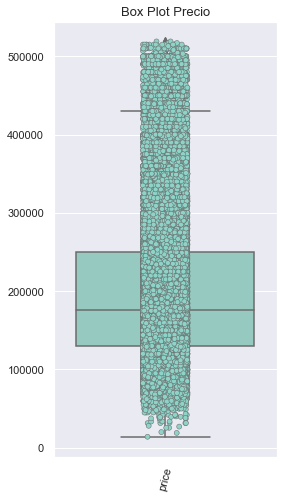

In [27]:
plt.rc("figure", figsize=(4, 8))

data_sin_out_price = data_sin_out[['price']]

plt.title('Box Plot Precio', fontsize = 13)

ax1 = sns.boxplot(data=data_sin_out_price, palette='Set3')
plt.setp(ax1.get_xticklabels(), rotation=75)
ax2 = sns.stripplot(data=data_sin_out_price,jitter=True, dodge=True, linewidth=0.5, palette='Set3')

Estudiando Ambientes, habitaciones y baños

In [28]:
# Ambientes

print('Min',df_mayores_ventas['rooms'].min(), 'Max', df_mayores_ventas['rooms'].max())

Min 1.0 Max 26.0


In [29]:
q25 = df_mayores_ventas['rooms'].quantile(0.25) 
q75 = df_mayores_ventas['rooms'].quantile(0.75)
iqr = q75 - q25
min_rm = q25 - 1.5*iqr
max_rm = q75 + 1.5*iqr

In [30]:
print(min_rm, max_rm)

-1.0 7.0


In [31]:
data_sin_out = data_sin_out[(data_sin_out['rooms'] > min_rm)&(data_sin_out['rooms'] < max_rm)]

In [34]:
# Habitaciones

print('Min',df_mayores_ventas['bedrooms'].min(), 'Max', df_mayores_ventas['bedrooms'].max())

Min 0.0 Max 15.0


In [35]:
q25 = df_mayores_ventas['bedrooms'].quantile(0.25) 
q75 = df_mayores_ventas['bedrooms'].quantile(0.75)
iqr = q75 - q25
min_be = q25 - 1.5*iqr
max_be = q75 + 1.5*iqr

In [36]:
print(min_be, max_be)

-2.0 6.0


In [37]:
data_sin_out = data_sin_out[(data_sin_out['bedrooms'] > min_be)&(data_sin_out['bedrooms'] < max_be)]

In [38]:
# Baños

print('Min',df_mayores_ventas['bathrooms'].min(), 'Max', df_mayores_ventas['bathrooms'].max())

Min 1.0 Max 12.0


In [39]:
q25 = df_mayores_ventas['bathrooms'].quantile(0.25) 
q75 = df_mayores_ventas['bathrooms'].quantile(0.75)
iqr = q75 - q25
min_ba = q25 - 1.5*iqr
max_ba = q75 + 1.5*iqr

In [40]:
print(min_ba, max_ba)

-0.5 3.5


In [41]:
data_sin_out = data_sin_out[(data_sin_out['bathrooms'] > min_ba)&(data_sin_out['bathrooms'] < max_ba)]

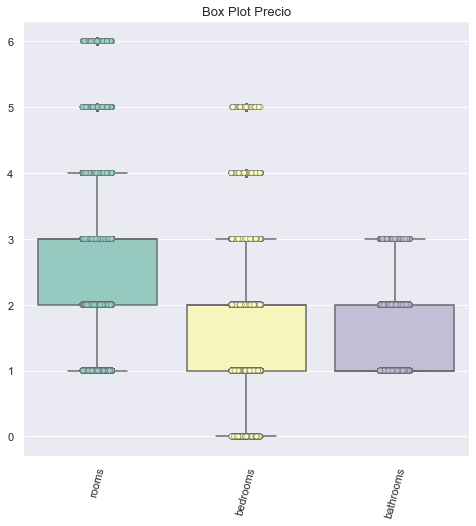

In [42]:
# Grafico

plt.rc("figure", figsize=(8, 8))

data_sin_out_rooms = data_sin_out[['rooms', 'bedrooms', 'bathrooms']]

plt.title('Box Plot Precio', fontsize = 13)

ax1 = sns.boxplot(data=data_sin_out_rooms, palette='Set3')
plt.setp(ax1.get_xticklabels(), rotation=75)
ax2 = sns.stripplot(data=data_sin_out_rooms,jitter=True, dodge=True, linewidth=0.5, palette='Set3')

Ahora volvemos a visualizar la distribución de cada una de las variables habiendo filtrado los valores outliers.

<AxesSubplot:xlabel='price'>

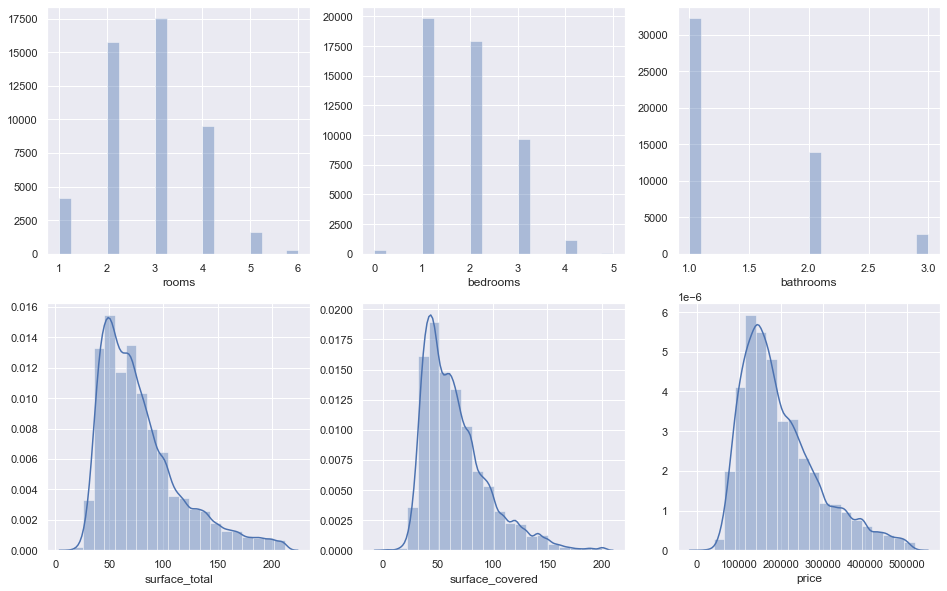

In [43]:
# Visualizamos la distribución de las variables 

plt.figure(figsize=(16,10))

plt.subplot(2, 3, 1)
sns.distplot(data_sin_out['rooms'], bins = 20, kde=False)

plt.subplot(2, 3, 2)
sns.distplot(data_sin_out['bedrooms'], bins = 20, kde=False)

plt.subplot(2, 3, 3)
sns.distplot(data_sin_out['bathrooms'], bins = 20, kde=False)

plt.subplot(2, 3, 4)
sns.distplot(data_sin_out['surface_total'], bins = 20)

plt.subplot(2, 3, 5)
sns.distplot(data_sin_out['surface_covered'], bins = 20)

plt.subplot(2, 3, 6)
sns.distplot(data_sin_out['price'], bins = 20)


Finalmente, observaremos la relación por tipo de propiedad entre cada una de las variables con las demás

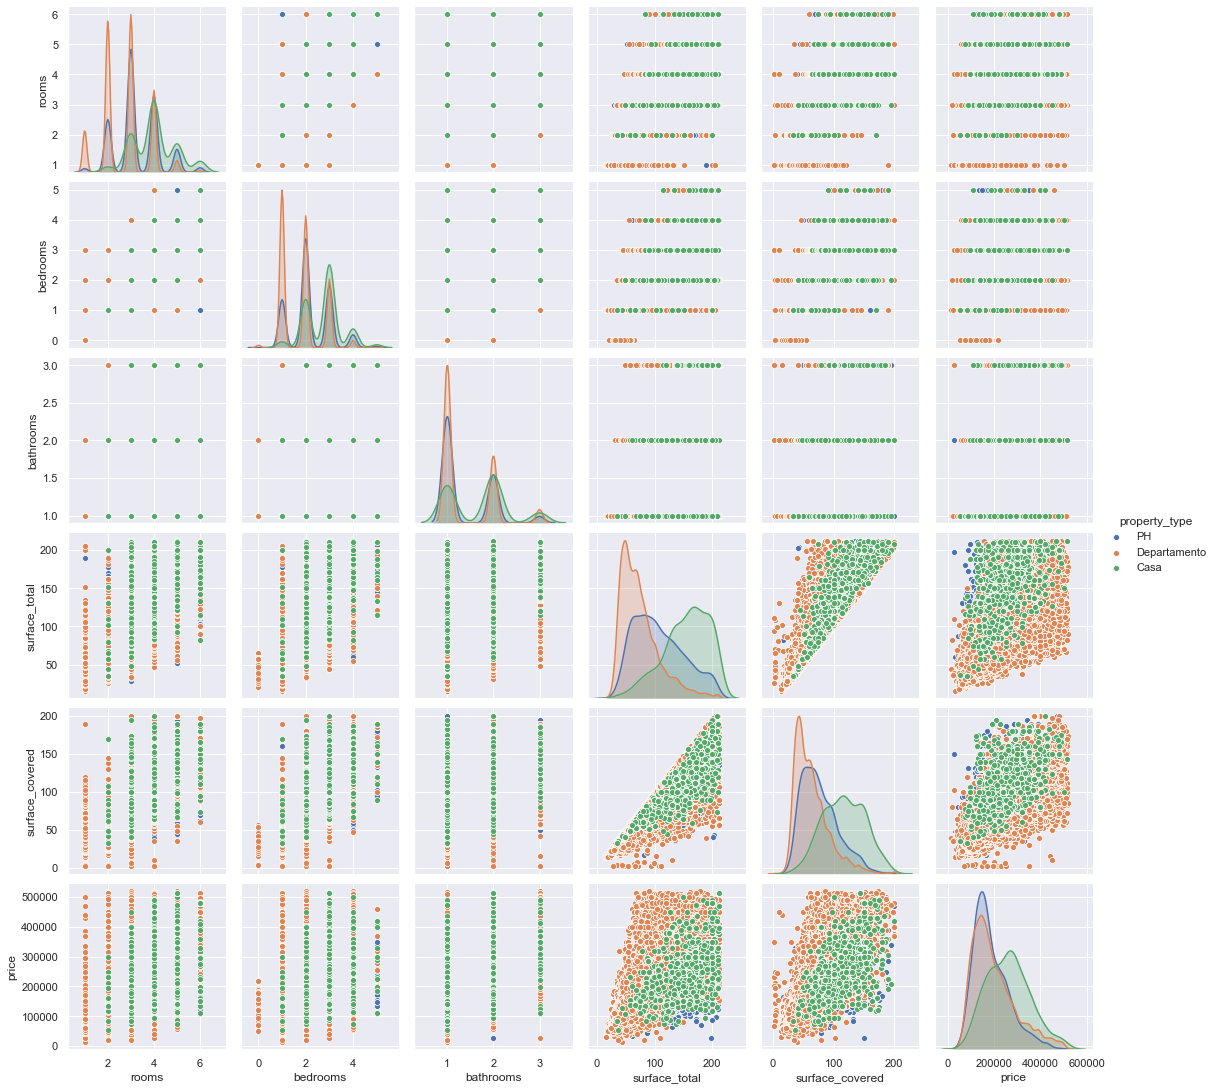

In [44]:
sns.pairplot(data_sin_out[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']], hue='property_type')

#### 2.7. Correlaciones: 
Se estudiará la correlación entre las variables `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`, `price`.

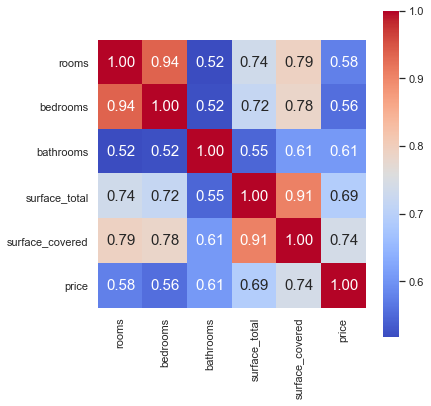

In [50]:
# Correlación total

corr = data_sin_out[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].corr().copy()
plt.figure(figsize=(6,6))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data_sin_out[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns, 
           yticklabels= data_sin_out[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.show()

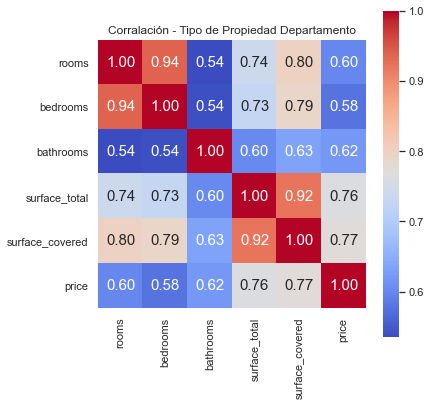

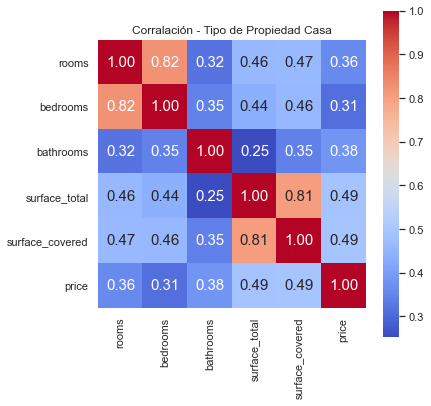

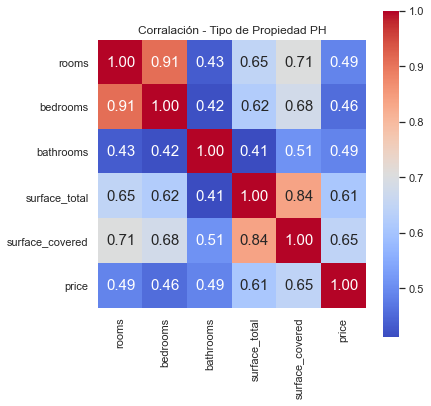

In [51]:
# Por tipo de propiedad:

# Departamento
data_dep = data_sin_out[data_sin_out['property_type']=='Departamento']
corr_dep = data_dep[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].corr().copy()

plt.figure(figsize=(6,6))
sns.heatmap(corr_dep, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data_dep[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns, 
           yticklabels= data_dep[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns,
           cmap= 'coolwarm')
plt.title('Corralación - Tipo de Propiedad Departamento')
plt.xticks(rotation = 90)
plt.show()


# Casa
data_casa = data_sin_out[data_sin_out['property_type']=='Casa']
corr_casa = data_casa[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].corr().copy()

plt.figure(figsize=(6,6))
sns.heatmap(corr_casa, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data_casa[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns, 
           yticklabels= data_casa[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns,
           cmap= 'coolwarm')
plt.title('Corralación - Tipo de Propiedad Casa')
plt.xticks(rotation = 90)
plt.show()


# PH
data_PH = data_sin_out[data_sin_out['property_type']=='PH']
corr_PH = data_PH[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].corr().copy()

plt.figure(figsize=(6,6))
sns.heatmap(corr_PH, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= data_PH[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns, 
           yticklabels= data_PH[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].columns,
           cmap= 'coolwarm')
plt.title('Corralación - Tipo de Propiedad PH')
plt.xticks(rotation = 90)
plt.show()

Se puede observar que para PH y Casa, las variables seleccionadas no tienen tanta correlación con Precio como lo tienen para Departamento.

### 2.2 Desafío: Análisis adicionales

#### 2.2.1 Análisis por Precio en Capital Federal
En este apartado analizaremos las variaciones de la variable Precio desde distintas perspectivas:

1. Observar su variación respecto al Barrio
2. Observar su respecto a la cantidad de Ambientes
3. Observar si hay una diferencia estadística significativa ante la presencia de amenities.

Tomaremos las instancias pertenecientes a Capital Federal, ya que serán las se utilizarán como input del modelo.

In [24]:
# Importo el dataset
data = pd.read_csv(r'DS_Proyecto_01_Datos_Properati.csv')

data = data[(data['l2']=='Capital Federal')& (data['price'] <= 4000000)]

1) Precio respecto al Barrio:

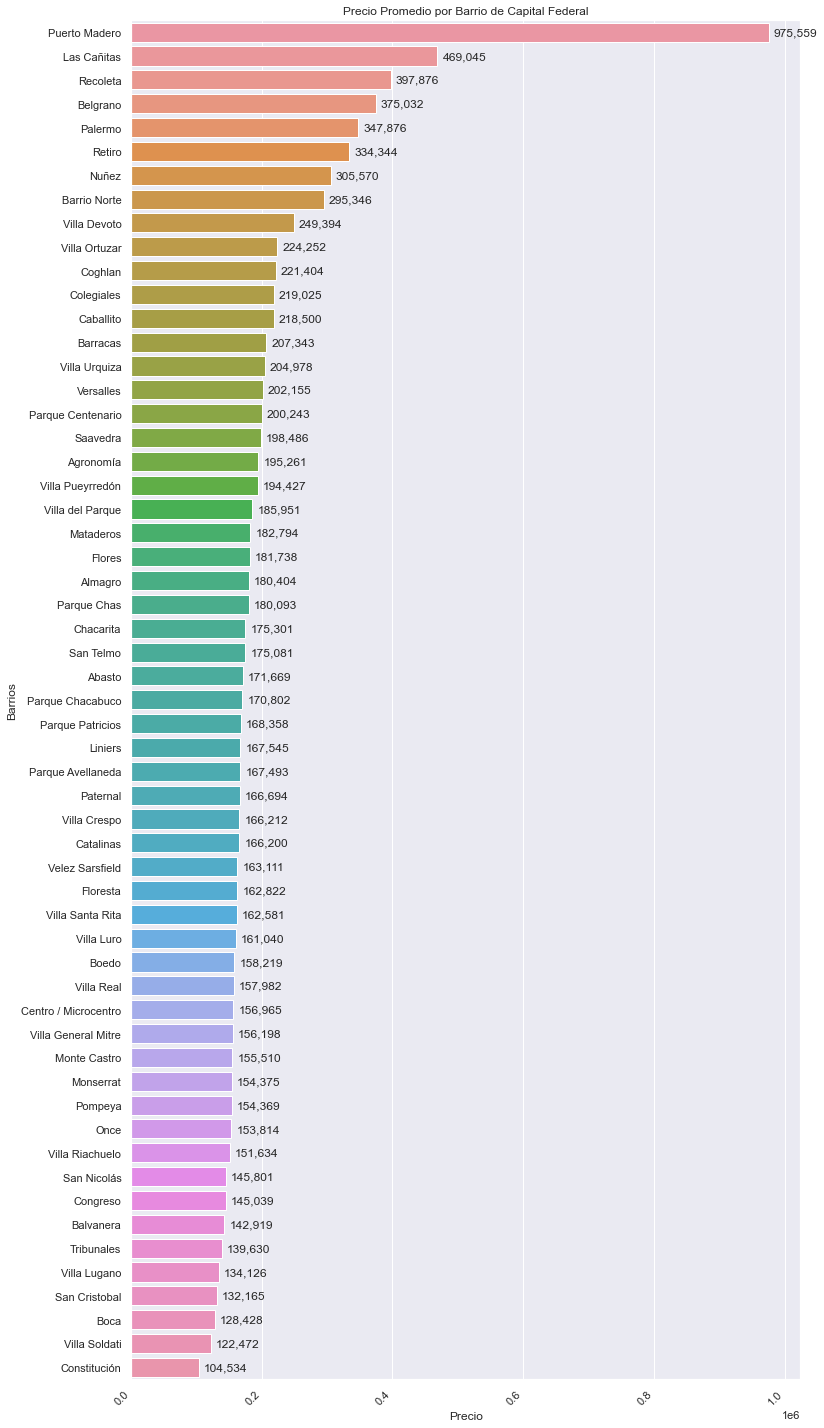

In [25]:
plt.figure(figsize=(12,25))

order = data.groupby('l3')['price'].mean().sort_values(ascending=False).index.values

g5 = sns.barplot(x=data['price'], y=data['l3'], data=data, estimator= np.mean, order=order, ci=None)
plt.setp(g5.get_xticklabels(), rotation=45, ha='right')

plt.title('Precio Promedio por Barrio de Capital Federal')
plt.xlabel('Precio')
plt.ylabel('Barrios')

for p in g5.patches:
    g5.annotate('{:,.0f}'.format(p.get_width()), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

Con cierto conocimiento previo del mercado inmobiliario en Capital Federal y apoyados en este gráfico, sabemos que hay ciertos barrios que no bajarán de un precio mínimo como Puerto Madero y otros que no subirán de un precio máximo como Constitución. 

En este orden de ideas, podría ser propicio agregar una variable que agrupe por "Niveles" a los barrios en función de su precio, sabiendo que un tasador tomará de igual forma al barrio como parámetro del precio final de la inmueble independientemente de las características de la misma.

2) Precio respecto a la cantidad de Ambientes:

Continuamos con las instancias pertenecientes a Capital Federal.

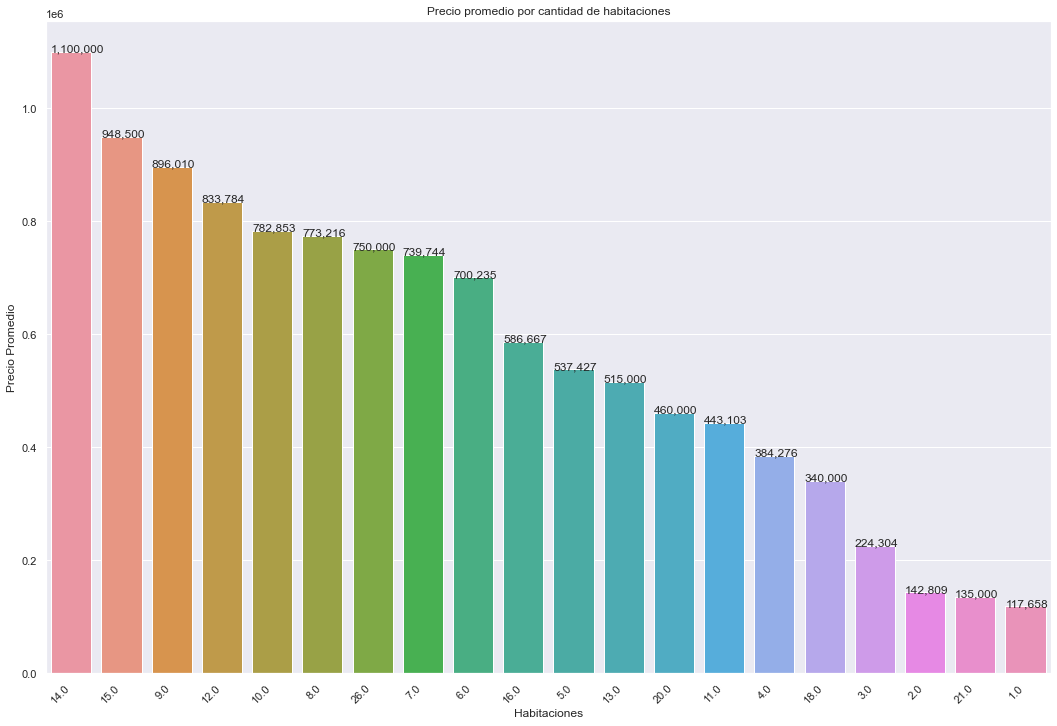

In [26]:
plt.figure(figsize=(18,12))

order = data.groupby('rooms')['price'].mean().sort_values(ascending=False).index.values

g6 = sns.barplot(x='rooms', y='price', data=data, order=order, estimator = np.mean, ci=None)
plt.setp(g6.get_xticklabels(), rotation=45, ha='right')


plt.title('Precio promedio por cantidad de habitaciones')
plt.xlabel('Habitaciones')
plt.ylabel('Precio Promedio')


for p in g6.patches:
    g6.annotate('{:,.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+5))

3) **Nos responderemos a la pregunta:** ¿Exite diferencia en el precio promedio de ventas de los departamentos con amenities de los sin amenities?

Inciaremos construyendo la variable amenities a partir de la descripción de cada instancias. Luego, observaremos su distribución.

In [27]:
# Consutruyo a partir de la descripción del inmueble, una variable flag que indique si la instancia tiene o no amenities
data['amenities'] = np.where(data['description'].str.contains('amenities', case=False), 1, 0)

In [28]:
data['amenities'].value_counts()

0    80986
1    11508
Name: amenities, dtype: int64

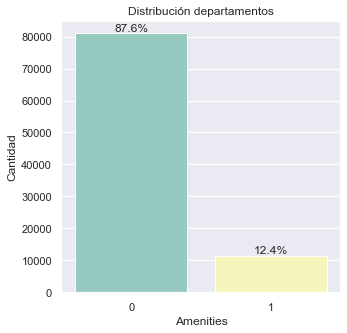

In [29]:
# Grafico la relación entre ambos grupos

plt.figure(figsize=(5,5))

g = sns.countplot(data = data, x = 'amenities', orient="v", palette ='Set3')
#plt.setp(g.get_xticklabels())

plt.title('Distribución departamentos')
plt.xlabel('Amenities')
plt.ylabel('Cantidad')


for p in g.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    g.annotate('{:.1f}%'.format(100.*y/len(data)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

Comparamos distribución, media y mediana de ambas muestras

In [30]:
from scipy.stats import median_test

Media Precio con Amenities: 394.865
Media Precio sin Amenities: 238.646


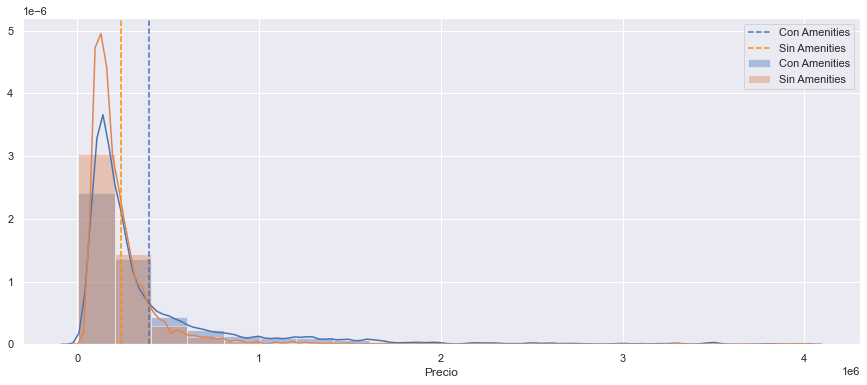

In [31]:
plt.figure(figsize=(15,6))

g1=sns.distplot(data['price'][data['amenities']==1], bins = 20, label = 'Con Amenities')
g2=sns.distplot(data['price'][data['amenities']==0], bins = 20, label = 'Sin Amenities')

mean1 = data['price'][data['amenities']==1].mean()
mean2 = data['price'][data['amenities']==0].mean()

g1.axvline(mean1, color='b', linestyle='--', label='Con Amenities')
g2.axvline(mean2, color='darkorange', linestyle='--', label='Sin Amenities')

plt.xlabel('Precio')
plt.legend()


print('Media Precio con Amenities:',f'{mean1:,.0f}'.replace(',','.'))
print('Media Precio sin Amenities:',f'{mean2:,.0f}'.replace(',','.'))

Se observa que el promedio de los precios de ventas de los departamentos con amenities en Capital Federal, son considerablemente mayores a los sin amenities.

Sin embargo, cabe considerar si esta tiene la suficiente significancia estadística para afirmar que ambos medias no son iguales dada la muestra y la distribución de los datos seleccionados. Por ello, se realizará un T test de dos muestras.

Prueba T de dos muestras: Compara las medias de dos grupos independientes para determinar si existe evidencia estadística de que las medias de la población asociada son significativamente diferentes. La prueba t de muestras independientes es una prueba paramétrica . Esta prueba también se conoce como: Independent t Test.

Hipótesis

**H0:** La diferencia entre ambas medias es igual a 0

**H1:** La diferencia entre ambas medias es distinta de 0

In [32]:
from scipy.stats import ttest_ind

In [33]:
Ttest,p = ttest_ind(data['price'][data['amenities']==1],data['price'][data['amenities']==0], equal_var=False)


if p <0.05:
    print('Se rechaza Hipotesis Nula')
else:
    print('Se acepta la hipótesis Nula')

Se rechaza Hipotesis Nula


Es decir, con un nivel de significancia del 5% podemos afirmar que ambas medias no son iguales.

Sin embargo, considerando la presencia fuerte de valores outliers, cabe también analizar la mediana ya que en este caso puede ser más representativa.

Mediana Precio con Amenities: 215.000
Mediana Precio sin Amenities: 173.000


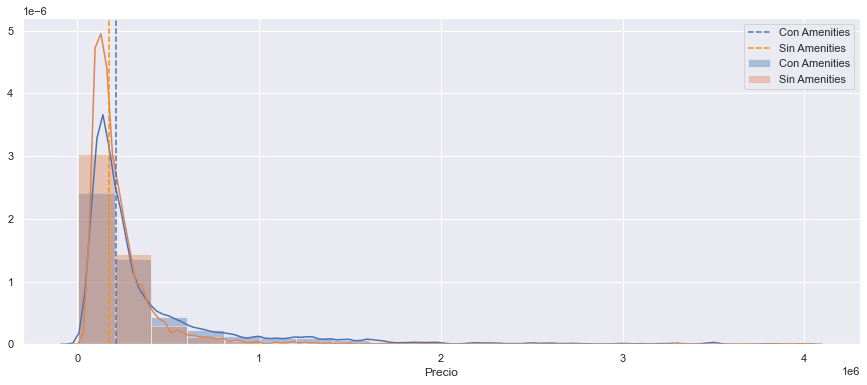

In [34]:
plt.figure(figsize=(15,6))

g1=sns.distplot(data['price'][data['amenities']==1], bins = 20, label = 'Con Amenities')
g2=sns.distplot(data['price'][data['amenities']==0], bins = 20, label = 'Sin Amenities')

median1 = data['price'][data['amenities']==1].median()
median2 = data['price'][data['amenities']==0].median()

g1.axvline(median1, color='b', linestyle='--', label='Con Amenities')
g2.axvline(median2, color='darkorange', linestyle='--', label='Sin Amenities')

plt.xlabel('Precio')
plt.legend()


print('Mediana Precio con Amenities:',f'{median1:,.0f}'.replace(',','.'))
print('Mediana Precio sin Amenities:',f'{median2:,.0f}'.replace(',','.'))

In [35]:
from scipy.stats import median_test

**H0:** La diferencia entre ambas medianas es igual a 0

**H1:** La diferencia entre ambas medinas es distinta de 0

In [36]:
g1 = data['price'][data['amenities']==1]
g2 = data['price'][data['amenities']==0]


stat, p, med, tbl = median_test(g1, g2)

if p <0.05:
    print('Se rechaza Hipotesis Nula')
else:
    print('Se acepta la hipótesis Nula')

Se rechaza Hipotesis Nula


Nuevamente, con un nivel de significancia del 5% podemos afirmar que ambas medianas no son iguales.

Conclusión: Este análisis nos da un indicio de que agregar al modelo la variable Amenities puede ayudar a la performance del mismo.

In [37]:
# Importo dataset de equivalencias en la nomenclartura de los barrios entre un dataset y el otro

equivalencia_barrios=pd.read_excel('Equivalencia_barrios.xlsx')

In [38]:
data=data.merge(equivalencia_barrios, how='left', on=['l3'])

In [39]:
data.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,...,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,amenities,barrio
0,2019-10-17,2019-12-23,2019-10-17,-34.6,-58.4,Argentina,Capital Federal,San Cristobal,7.0,7.0,...,140.0,140.0,"153,000.0",USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,0,SAN CRISTOBAL
1,2019-10-17,2019-11-21,2019-10-17,-34.6,-58.4,Argentina,Capital Federal,Boedo,2.0,1.0,...,70.0,58.0,"159,000.0",USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0,BOEDO


### 2.3 Desafío: Incorporando información externa

**2.3.1 Nos responderemos a la pregunta:**
¿Existe una relación entre el Precio del inmueble y el nivel de criminalidad del barrio al que corresponde?


A fin de respondernos esta pregrunta, nos ayudaremos de un dataset externo que contiene la cantidad de delitos denunciados en Capital Federal desde el año 2016 a 2018. Si bien nuestro dataset tiene información del 2019-2020, asumiremos que es una buena aproximación del indice de criminalidad general que tiene cada barrio en promedio.

Información del dataset:

* **id** - Identificador único del delito
* **comuna** - Nombre de la comuna
* **barrio** - Nombre del barrio
* **latitud** - Latitud del lugar del delito
* **longitud** - Longitud del lugar del delito
* **fecha** - Fecha del delito en formato YYYY-MM-DD
* **hora** - Hora del delito en formato hh:mm:ss
* **uso_arma** - Describe si el robo fue armado
* **uso_moto** - Describe si el robo fue por "motochorro"
* **origen_dato** - Describe el origen de la denuncia
* **tipo_delito** - Describe el tipo de delito
* **cantidad_vehiculos** - Cantidad de vehículos involucrados
* **cantidad_victimas** - Cantidad de víctimas fatales


Fuente: https://github.com/ramadis/delitos-caba

In [49]:
# Importo el dataset
delitos = pd.read_csv('delitos.csv', usecols= ['comuna','barrio', 'fecha', 'tipo_delito'])

# Creo una variable para sumar los casos
delitos['cuenta'] = 1

# Transformo el tipo de variable a fecha
delitos['fecha'] = pd.DataFrame(delitos['fecha'], dtype="datetime64[ns]")

In [50]:
delitos.head()

,comuna,barrio,fecha,tipo_delito,cuenta
0,Comuna 7,FLORES,2016-01-31,Homicidio Doloso,1
1,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1
2,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1
3,Comuna 10,VILLA REAL,2016-01-31,Hurto Automotor,1
4,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1


In [51]:
# Creo la variable año
delitos['year'] = pd.DatetimeIndex(delitos['fecha']).year

# Creo la variable mes
delitos['month'] = pd.DatetimeIndex(delitos['fecha']).month

# Creo la variable periodo a partir de las dos anteriores
delitos['periodo'] = delitos['year'].astype(str).str.cat(delitos['month'].astype(str), sep='-')

# Elimino las variables que ya no voy a usar
delitos = delitos.drop(['year','month'],1)

In [52]:
delitos.head()

,comuna,barrio,fecha,tipo_delito,cuenta,periodo
0,Comuna 7,FLORES,2016-01-31,Homicidio Doloso,1,2016-1
1,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1,2016-1
2,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1,2016-1
3,Comuna 10,VILLA REAL,2016-01-31,Hurto Automotor,1,2016-1
4,Comuna 9,LINIERS,2016-01-31,Robo (Con violencia),1,2016-1


In [53]:
# Obtengo la suma de delitos denunciados por barrio y período

delitos = delitos.groupby(['barrio','periodo'], as_index=False)['cuenta'].sum()
delitos = delitos.rename(columns = {'cuenta':'total_periodo'})

In [54]:
delitos.head()

,barrio,periodo,total_periodo
0,AGRONOMIA,2016-1,24
1,AGRONOMIA,2016-10,33
2,AGRONOMIA,2016-11,33
3,AGRONOMIA,2016-12,30
4,AGRONOMIA,2016-2,31


In [55]:
# Obtengo el promedio de delitos mensuales por barrio

delitos = delitos.groupby(['barrio'], as_index=False)['total_periodo'].mean()
delitos = delitos.rename(columns = {'total_periodo':'delitos_promedio_mensual'})
delitos['delitos_promedio_mensual'] = delitos['delitos_promedio_mensual'].round(0)

In [56]:
delitos.head()

,barrio,delitos_promedio_mensual
0,AGRONOMIA,36.0
1,ALMAGRO,398.0
2,BALVANERA,644.0
3,BARRACAS,278.0
4,BELGRANO,320.0


In [57]:
# Obtengo el preico promedio por barrio

precio_prom = data.groupby(['barrio'], as_index=False)['price'].mean()

precio_prom = precio_prom.rename(columns = {'price':'precio_promedio'})

In [58]:
precio_prom.head()

,barrio,precio_promedio
0,AGRONOMIA,"195,261.4"
1,ALMAGRO,"180,403.8"
2,BALVANERA,"148,074.2"
3,BARRACAS,"207,342.6"
4,BELGRANO,"349,711.6"


In [59]:
# Joineo la tabla que agrega al precio promedio por barrio
delitos=delitos.merge(precio_prom, how='left', on=['barrio'])

In [60]:
delitos.head()

,barrio,delitos_promedio_mensual,precio_promedio
0,AGRONOMIA,36.0,"195,261.4"
1,ALMAGRO,398.0,"180,403.8"
2,BALVANERA,644.0,"148,074.2"
3,BARRACAS,278.0,"207,342.6"
4,BELGRANO,320.0,"349,711.6"


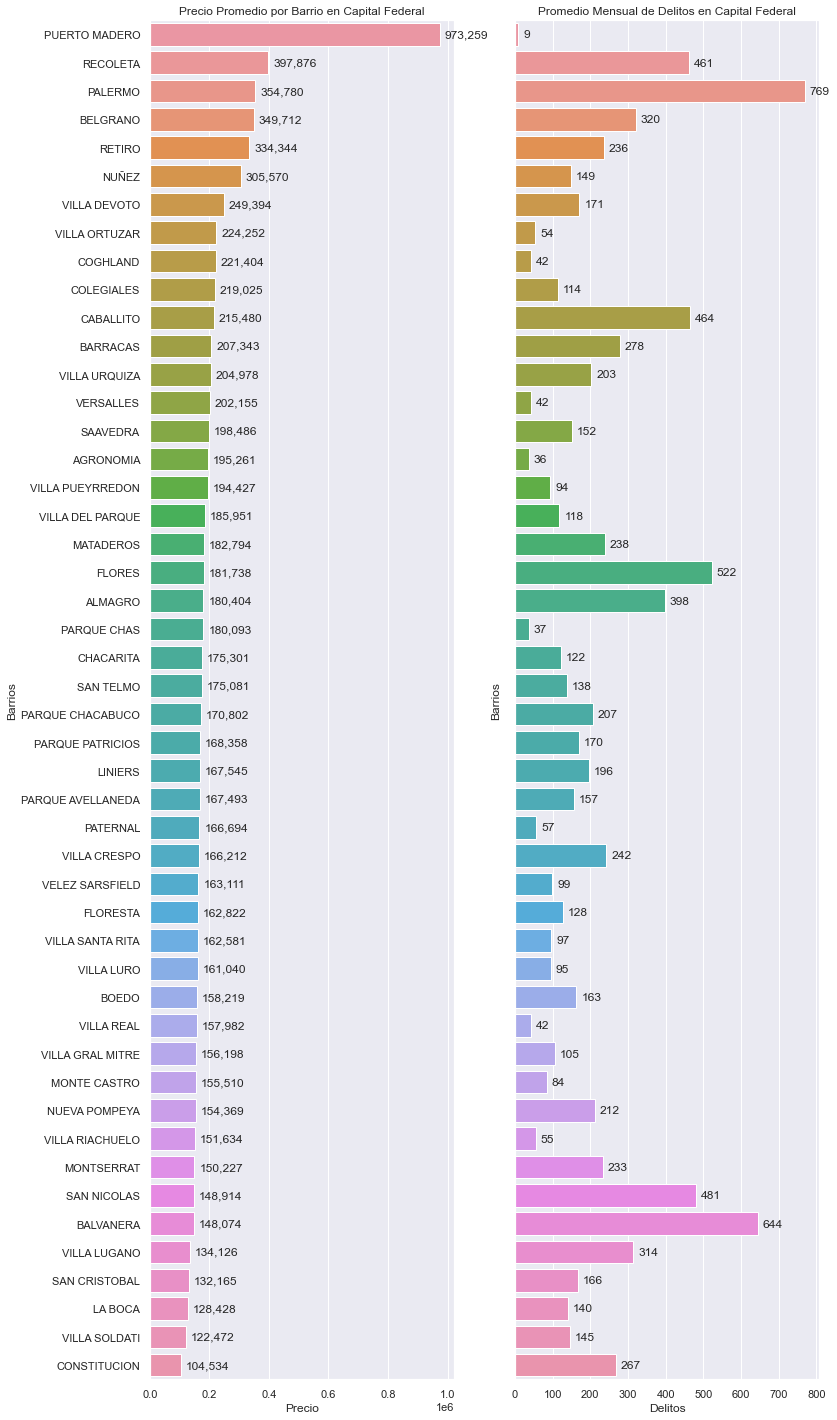

In [70]:
#plt.figure(figsize=(12,25))

plt.rc("figure", figsize=(12, 25))

order = delitos.groupby('barrio')['delitos_promedio_mensual'].sum().sort_values(ascending=False).index.values

# Grafico

plt.subplot(1, 2, 1)

order = delitos.groupby('barrio')['precio_promedio'].sum().sort_values(ascending=False).index.values

g1 = sns.barplot(x=delitos['precio_promedio'], y=delitos['barrio'], data=delitos, order=order, ci=None)
#plt.setp(g1.get_xticklabels(), rotation=45, ha='right')

plt.title('Precio Promedio por Barrio en Capital Federal')
plt.xlabel('Precio')
plt.ylabel('Barrios')

for p in g1.patches:
    g1.annotate('{:,.0f}'.format(p.get_width()), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# Grafico
plt.subplot(1, 2, 2)

g2 = sns.barplot(x=delitos['delitos_promedio_mensual'], y=delitos['barrio'], data=delitos, estimator= np.sum, order=order, ci=None)
g2.set(yticklabels=[])
g2.set(ylabel=None)

#plt.setp(g2.get_xticklabels(), rotation=45, ha='right')

plt.title('Promedio Mensual de Delitos en Capital Federal')
plt.xlabel('Delitos')
plt.ylabel('Barrios')

for p in g2.patches:
    g2.annotate('{:,.0f}'.format(p.get_width()), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")


El precedente gráfico nos muestra por un lado el precio promedio por barrio, y por el otro la cantidad de denuncias promedio mensuales de dicho barrio. 

La intuición detrás de este análisis es que el índice de criminalidad y el precio promedio por barrio de un inmuble debiesen presentar una correlación negativa, es decir, a mayor cantidad de denuncias menor el precio promedio. Sin embargo, podemos observar que no hay una relación aparente. Dos ejemplos que lo demuestran son Puerto Medero y Palermo, ambos de los barrios mas caros, pero el primero tiene la menor cantidad de denuncias promedias registradas y el segundo la mayor de todas.

### 3. Machine Learning

En esta sección, se entrenarán los modelos de Machine Learning. El dataset de entrada responderá a los siguientes puntos:

1. Propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
2. Propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
3. Propiedades cuya precio es menor 4000000 dólares.
4. Columnas `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered` y `price`.
5. Se descartarán aquellas instancias con valores faltantes.

Obtengo los datos

In [2]:
# Importo el dataset
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

# Filtro las propiedades que no cumplen con las carácterísticas solicitadas

data = data[(data['property_type']=='Departamento')|(data['property_type']=='Casa')|(data['property_type']=='PH')]

data = data[data['l2']=='Capital Federal']

#data = data[data['surface_covered']<data['surface_total']]
data = data[(data['surface_total'] <= 1000) & (data['surface_total'] >= 15)]

data = data[data['price'] <= 4000000]


# Filtro las features que voy a utilizar
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
data = data[columns]

# Elimino valores nulos 
data = data.dropna()

In [3]:
data.shape

(81019, 6)

**Esta sección responderá a las siguientes iteraciones:**

1. Modelo de Benchmark: En dónde se entrenará el primer modelo con el dataset tal como se indica en la consigna.
2. Árboles de Decisión y Vecinos más cercanos: Se entrenarán ambos modelos y se evaluarán lo resultados.
3. Tuneo de Hiperparámetos:
    * Primero, se evalurá el modelo para distintos valores de un único hiperparámetro por modelo.
    * Segundo, se evalurá el modelo haciendo un k-fold validation por modelo.
4. Feature Engeneering: Se construirán nuevas variables para incluirlas como imput del modelo.
5. LGBM Regressor: Se probará la mejora en la predicción con un modelo de machine learning superador.

**Nota:** La métrica que se escogió para evaluar la performance es el Error Cuadrático Medio. Es decir, el objetivo de cada una de las iteraciones será lograr minimizarlo con un modelo estable tanto en train como test.

#### Train y Test

In [4]:
colname = data.columns.values.tolist()
predictors = colname[:5]
target = colname[5]

In [5]:
X = data[predictors]
y = data[target]

In [6]:
X.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered
0,7.0,7.0,2.0,140.0,140.0
1,2.0,1.0,2.0,70.0,58.0
2,2.0,1.0,1.0,45.0,45.0
3,2.0,1.0,1.0,85.0,50.0
5,2.0,1.0,1.0,56.0,56.0


In [7]:
y.head()

0   153,000.0
1   159,000.0
2   125,000.0
3   295,000.0
5   150,000.0
Name: price, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64815, 5) (64815,) (16204, 5) (16204,)


###  3.1 Modelo Benchmark
Se tomará al modelo de **Regresión Lineal** como punto de partida y comparación con los demás modelos.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [10]:
linear_model = LinearRegression()

In [11]:
linear_model.fit(X_train, y_train)

LinearRegression()

Raíz del error cuadrático medio en Train: 199.316
Raíz del error cuadrático medio en Test: 203.270


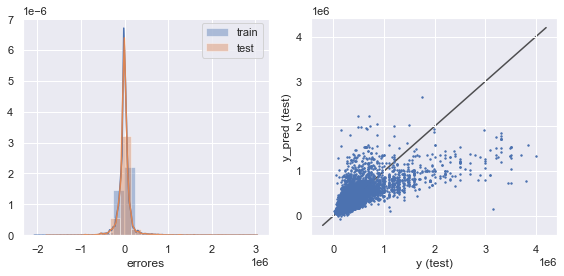

In [12]:
y_train_pred_b = linear_model.predict(X_train)
y_test_pred_b = linear_model.predict(X_test)
    
rmse_train_b = np.sqrt(mean_squared_error(y_train, y_train_pred_b))
rmse_test_b = np.sqrt(mean_squared_error(y_test, y_test_pred_b))

print('Raíz del error cuadrático medio en Train:',f'{rmse_train_b:,.0f}'.replace(',','.'))
print('Raíz del error cuadrático medio en Test:',f'{rmse_test_b:,.0f}'.replace(',','.'))
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_b, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_b, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_b, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

### 3.2 Árboles de Decisión y Vecinos más cercanos

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [14]:
tree_regressor = DecisionTreeRegressor()
knn_regressor = KNeighborsRegressor()

In [15]:
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 54.048
Raíz del error cuadrático medio en Test: 141.069


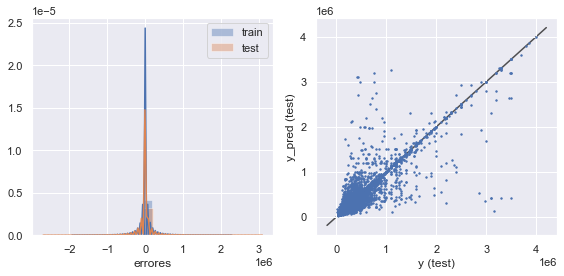

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 120.367
Raíz del error cuadrático medio en Test: 152.977


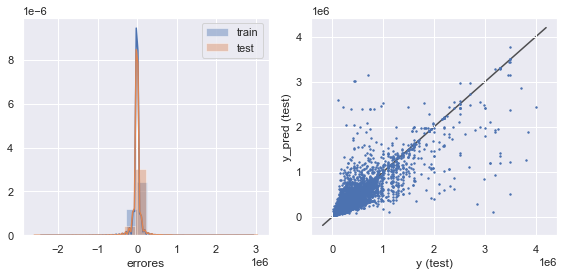

In [16]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
    print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**Comentarios**

Árbol de Decisión: Si bien tanto en el conjunto de entrenamiento como el de testeo se observan considerablemente menores que nuestro benchamark, la gran diferencia en la performance de ambos subconjuntos nos muestra que el modelo no es estable y overfitea. 

Vecinos más cercanos: Mejora el modelo de benchmark y es más estable que Árbol de Decisión ya que presenta menor ratio de error entre Train y Test.

### 3.3 Tunning de Hiperparámetros

### 3.3.1 Visualización de performance del modelo de a un hiperparámetro

In [56]:
from sklearn.metrics import mean_squared_error as mse

Árbol de decisión: Profundidad

In [31]:
max_depths = range(1, 20)
training_error = []
testing_error = []


for max_depth in max_depths:
    
    # Definir el modelo con el valor de vecinos deseado
    clf = DecisionTreeRegressor(max_depth= max_depth, random_state=42)
    #print(max_depth)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_err = mean_squared_error(y_train,y_train_pred)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_err = mean_squared_error(y_test,y_test_pred)    
    
    # Agregar la información a las listas
    training_error.append(train_err)
    testing_error.append(test_err)


In [33]:
# Encuentro la posición del mínimo error

error_dif = np.array(testing_error) - np.array(training_error)
list_numbers = list(error_dif)
element = min(error_dif)

20 - (len(list_numbers)-list_numbers.index(element))

1

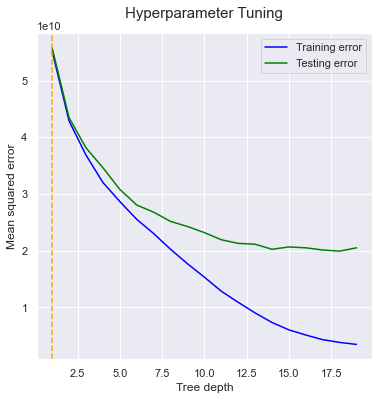

In [34]:
plt.rc("figure", figsize=(6, 6))
plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.axvline(x=1, color='orange', linestyle='--')
plt.annotate('optimum = 2', xy=(6.5, 1.17), color='red')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
#plt.savefig('error.png') 

Vecinos más Cercanos: k vecinos

In [21]:
n_neighbors = range(20, 100)
    
training_error = []
testing_error = []    
    
for n_neighbor in n_neighbors:
    
    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsRegressor(n_neighbors=n_neighbor)
    #print(max_depth)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_err = mean_squared_error(y_train,y_train_pred)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_err = mean_squared_error(y_test,y_test_pred)    
    
    # Agregar la información a las listas
    training_error.append(train_err)
    testing_error.append(test_err)

In [22]:
# Encuentro la posición del mínimo error

error_dif = np.array(testing_error) - np.array(training_error)
list_numbers = list(error_dif)
element = min(error_dif)

100 - (len(list_numbers)-list_numbers.index(element))

87

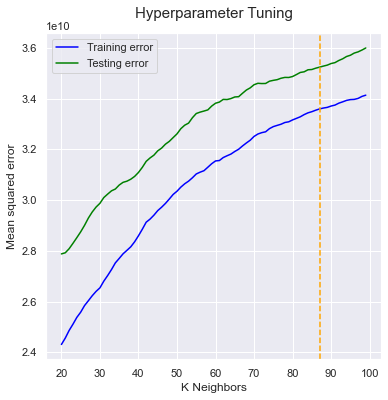

In [24]:
plt.rc("figure", figsize=(6, 6))
plt.plot(n_neighbors, training_error, color='blue', label='Training error')
plt.plot(n_neighbors, testing_error, color='green', label='Testing error')
plt.xlabel('K Neighbors')
plt.axvline(x=87, color='orange', linestyle='--')
#plt.annotate('optimum = 2', xy=(6.5, 1.17), color='red')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()
#plt.savefig('error.png')

In [35]:
tree_regressor = DecisionTreeRegressor(max_depth= 1)
knn_regressor = KNeighborsRegressor(n_neighbors= 87)

In [36]:
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=87)

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 234.917
Raíz del error cuadrático medio en Test: 236.141


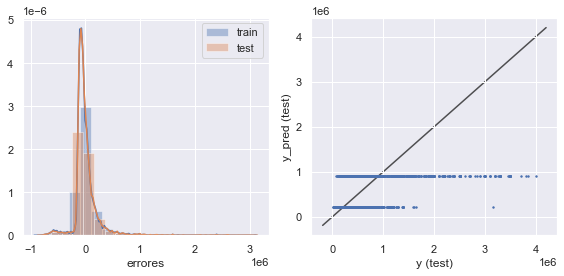

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 183.288
Raíz del error cuadrático medio en Test: 187.725


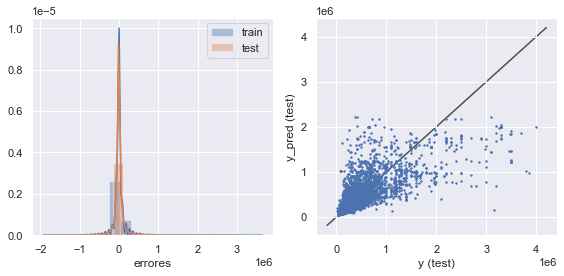

In [37]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
    print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**Comentarios**

Probando con la optimización del hiperparámetro max_depth para el caso del modelo de Arbol de Decisión y n_neighbors para Vecinos más cercanos, por un lado obtenemos modelos más estables pero por el otro obtenemos un mayor error.

Esto nos da el indicio de que probar un único parámetro por modelo no es suficiente para ésta problemática, por ello se trabajará con una optimización de hiperparámetros más completa.

### 3.3.2 K fold validation

Árboles de decisión

In [190]:
from sklearn.model_selection import GridSearchCV

In [62]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

model = DecisionTreeRegressor(random_state=42)
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=5)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
48543322830.86809


Vecinos más cercanos

In [64]:
param_grid = {'n_neighbors': np.arange(1, 12, 2),
              'weights': ['uniform', 'distance']}


parameters={'metric': ['minkowski','euclidean'],
            'n_neighbors': [15,16,18,20,23,25,30,50,70,90,95,100,110],
            'weights':['uniform','distance']
           }

model = KNeighborsRegressor()
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=5)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'distance'}
16532238915.108667


#### Entrenamos el modelo con los nuevos hiperparámetros

In [54]:
tree_regressor = DecisionTreeRegressor(max_depth= 5, max_features= 'auto', min_samples_leaf= 1, splitter= 'best')
knn_regressor = KNeighborsRegressor(metric= 'minkowski', n_neighbors= 20, weights= 'distance')

In [55]:
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20, weights='distance')

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 169.354
Raíz del error cuadrático medio en Test: 175.558


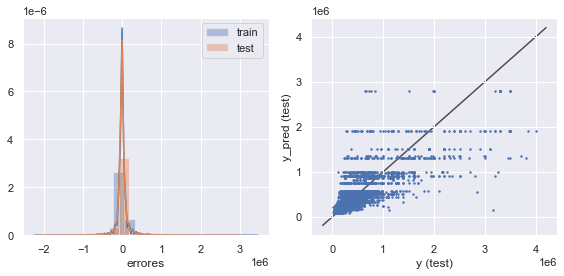

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 54.222
Raíz del error cuadrático medio en Test: 124.371


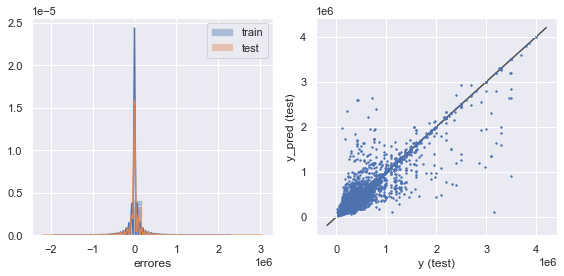

In [56]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
    print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**Comentarios**

Probando con la optimización de hiperparámetros con la técnica k-fold validation, obtenemos mejoras significativas para el caso del modelo de Arbol de Decisión pero un overfiting muy marcado en el caso de Vecinos más cercanos.

Sin embargo, el  Arbol de Decisión obtenido es el mejor obtenido en términos de la minimización del error y de la estabilidad de este.

### 3.4 Feature Engeneering

Luego de pruebas previas que no se incluirán en este proyecto por no haber tenido resultados positivos respecto al modelo, en esta iteración, volveremos a importar el dataset y construirmos las siguientes variables con el propósito de mejorar la predicción obtenida hasta ahora.

In [69]:
# Importo el dataset
data = pd.read_csv(r'C:\Users\Erika\Desktop\ACÁMICA\Sprint Proyect 1\DS_Proyecto_01_Datos_Properati.csv')

# Filtro las propiedades que no cumplen con las carácterísticas solicitadas

data = data[(data['property_type']=='Departamento')|(data['property_type']=='Casa')|(data['property_type']=='PH')]

data = data[data['l2']=='Capital Federal']

#data = data[data['surface_covered']<data['surface_total']]
data = data[(data['surface_total'] <= 1000) & (data['surface_total'] >= 15)]

data_fe = data[data['price'] <= 4000000].copy()


Nivel por Barrio: Se construyen las variables High Level, Medium High Level y Low Level. Se deja por fuera del dataset Medium Low Level para evitar la multicolinialidad.

In [70]:
data_fe['high_level'] = np.where(data_fe['l3']=='Puerto Madero', 1, 0)

In [71]:
data_fe['medium_high_level'] = np.where((data_fe['l3']=='Las Cañitas')|
                                        (data_fe['l3']=='Recoleta')| 
                                        (data_fe['l3']=='Belgrano')| 
                                        (data_fe['l3']=='Coghlan')| 
                                        (data_fe['l3']=='Colegiales')| 
                                        (data_fe['l3']=='Parque Centenario')| 
                                        (data_fe['l3']=='Barrio Norte')| 
                                        (data_fe['l3']=='Palermo')| 
                                        (data_fe['l3']=='Retiro')| 
                                        (data_fe['l3']=='Nuñez')| 
                                        (data_fe['l3']=='Villa Devoto')| 
                                        (data_fe['l3']=='Caballito')| 
                                        (data_fe['l3']=='Barracas')| 
                                        (data_fe['l3']=='Villa Urquiza')| 
                                        (data_fe['l3']=='Versalles') 
                                        , 1, 0).copy()

In [72]:
data_fe['low_level'] = np.where((data_fe['l3']=='Las Once')|
                                (data_fe['l3']=='Villa Riachuelo')| 
                                (data_fe['l3']=='Centro / Microcentro')| 
                                (data_fe['l3']=='Congreso')| 
                                (data_fe['l3']=='Balvanera')|
                                (data_fe['l3']=='Parque Avellaneda')| 
                                (data_fe['l3']=='San Cristobal')|
                                (data_fe['l3']=='Tribunales')| 
                                (data_fe['l3']=='San Nicolás')| 
                                (data_fe['l3']=='Villa Lugano')|
                                (data_fe['l3']=='Villa Devoto')|
                                (data_fe['l3']=='Villa Soldati')|
                                (data_fe['l3']=='Boca')|
                                (data_fe['l3']=='Villa Urquiza')|
                                (data_fe['l3']=='Constitución')
                                , 1, 0).copy().copy()

Características de la Propiedad / Edificio: A partir de la descripción de la publicación de venta, se extraerán palabras claves que nos permitan extraer más información sobre el inmuble.

In [73]:
data_fe['amenities'] = np.where(data_fe['description'].str.contains('amenities', case=False), 1, 0).copy()

In [74]:
data_fe['pileta'] = np.where(data_fe['description'].str.contains('pileta', case=False), 1, 0).copy()

In [75]:
data_fe['kitchenette'] = np.where(data_fe['description'].str.contains('kitchenette', case=False), 1, 0).copy()

In [76]:
data_fe['estrenar'] = np.where(data_fe['description'].str.contains('estrenar', case=False), 1, 0).copy()

In [77]:
data_fe['terraza'] = np.where(data_fe['description'].str.contains('terraza', case=False), 1, 0).copy()

In [78]:
data_fe['balcon'] = np.where(data_fe['description'].str.contains('balcon', case=False), 1, 0).copy()

In [79]:
data_fe['patio'] = np.where(data_fe['description'].str.contains('patio', case=False), 1, 0).copy()

In [80]:
data_fe['transporte'] = np.where(data_fe['description'].str.contains('subte', case=False)|
                                 data_fe['description'].str.contains('tren', case=False)|
                                 data_fe['description'].str.contains('trensporte', case=False), 1, 0).copy()

In [81]:
data_fe['cochera'] = np.where(data_fe['description'].str.contains('cochera', case=False), 1, 0).copy()

In [82]:
data_fe['sol'] = np.where(data_fe['description'].str.contains('sol', case=False) | 
                          data_fe['description'].str.contains('luminoso', case=False)|
                          data_fe['description'].str.contains('soleado', case=False)|
                          data_fe['description'].str.contains('luz', case=False), 1, 0).copy()

In [83]:
data_fe['pozo'] = np.where(data_fe['description'].str.contains('pozo', case=False), 1, 0).copy()

In [84]:
data_fe['estrenar'] = np.where(data_fe['description'].str.contains('estrenar', case=False), 1, 0).copy()

In [85]:
data_fe['facultad'] = np.where(data_fe['description'].str.contains('facultad', case=False) | 
                          data_fe['description'].str.contains('facultades', case=False)|
                          data_fe['description'].str.contains('universidad', case=False)|
                          data_fe['description'].str.contains('universidades', case=False), 1, 0).copy()

Relaciones entre variables: Se crean relaciones entre las variables con más correlación respecto al precio, para poder obtener relaciones transversales.

In [86]:
data_fe['rel_bath_room'] = data_fe['bedrooms']/data_fe['rooms'].copy()

In [87]:
data_fe['rel_sup_room'] = data_fe['surface_total']/data_fe['rooms'].copy()

In [88]:
# Elimino valores nulos 
data_fe = data_fe.dropna()

In [89]:
data_model = data_fe[list(data_fe.columns[7:].drop('price').insert(len(data_fe.columns)-6,'price'))]
data_model.shape

(76771, 29)

In [90]:
data_model.head(2)

,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,title,description,property_type,...,balcon,patio,transporte,cochera,sol,pozo,facultad,rel_bath_room,rel_sup_room,price
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,...,0,0,0,0,0,0,0,1.0,20.0,"153,000.0"
1,Boedo,2.0,1.0,2.0,70.0,58.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,...,0,1,0,0,1,0,0,0.5,35.0,"159,000.0"


Así pasamos de 5 features a 29. Para asegurarnos lo más posible de que no le estamos agregando ruido al modelo, evaluaremos la correlación de cada una de los features respecto al target y la variabilidad de si misma.

Como criterio, se fija un mínimo de correlación del 5% y un mínimo de variabilidad del 1%, las columnas que no lo cumplan serán descartadas.

In [91]:
corr = data_model.corr().copy()
sorted_corrs=corr['price'].abs().sort_values(ascending=False)

<AxesSubplot:>

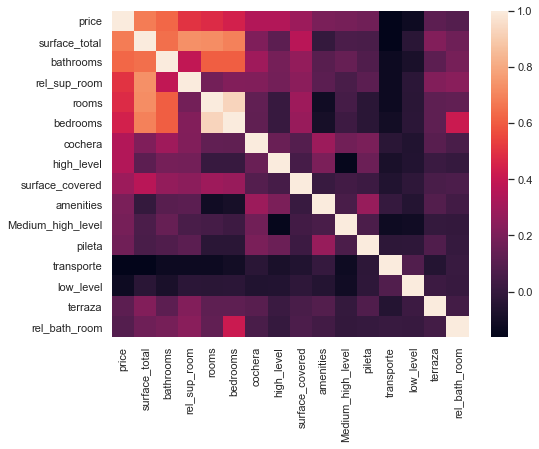

In [92]:
#strong correlation cut-off
a=0.05

#cutoff value for features variance(features with lower variance than this number will be dropped)
b=0.01

strong_corrs=sorted_corrs[sorted_corrs>a]
corrmatrix=data_model[strong_corrs.index].corr()
fig,ax=plt.subplots(figsize=(8,6))
sns.heatmap(corrmatrix,ax=ax)

In [93]:
X = data_model[list(strong_corrs.index.drop('price'))]
y = data_model['price']

Nuestro nuevo dataset pasó de 6 features a 15.

#### Entrenamos el modelo con las nuevas variables

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(61416, 15) (61416,) (15355, 15) (15355,)


In [95]:
linear_model = LinearRegression()
tree_regressor = DecisionTreeRegressor()
knn_regressor = KNeighborsRegressor()

In [96]:
linear_model.get_params(deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [97]:
tree_regressor.get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [98]:
knn_regressor.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [99]:
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [100]:
print(linear_model.coef_, linear_model.intercept_)

[ 2.54836298e+03  7.93717751e+04 -2.65328983e+03  3.15975483e+04
 -8.69764654e+04  5.76343531e+04  4.92304594e+05  5.12332414e+01
  8.18867547e+04  7.10342919e+04  3.71899987e+04 -8.45224721e+03
 -3.85566965e+04 -2.34837559e+04  1.40531860e+05] -105048.94365419957


### Evalúo comparativamente la performance de los 3 modelos
**Métrica elegida:** Error cuadrático medio

Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 174.135
Raíz del error cuadrático medio en Test: 161.061


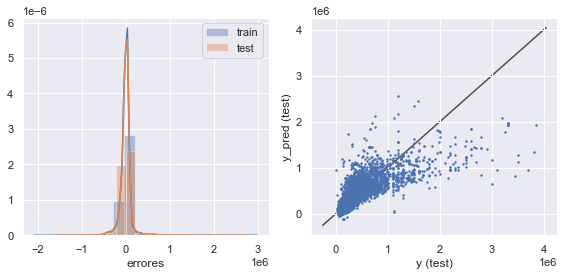

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 20.475
Raíz del error cuadrático medio en Test: 99.947


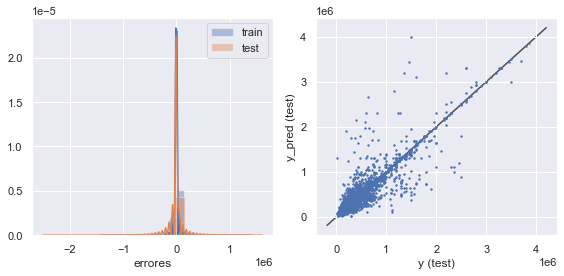

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 113.473
Raíz del error cuadrático medio en Test: 134.244


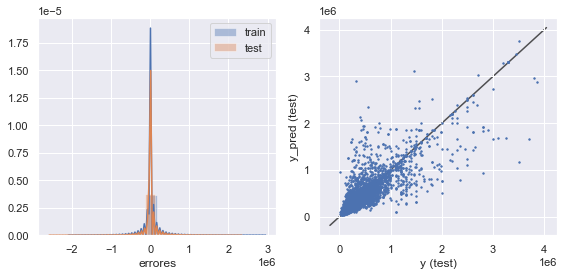

In [101]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([linear_model, tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
    print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**Comentarios**

Con la aplicación de feature engeneering obtenemos mejoras considerables en los 3 modelos sin haber aplicado la optimización de hiperparámetros. De los cuales, Vecinos más cercanos es el que presenta mejores resultados en términos de la minimización del error y la estabilidad entre train y test.

### Tunning de hiperparámetros con k fold

In [380]:
from sklearn.model_selection import GridSearchCV

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

model = DecisionTreeRegressor(random_state=42)
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=10)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
46828660188.999794


In [392]:
#param_grid = {'n_neighbors': np.arange(1, 12, 2),
#              'weights': ['uniform', 'distance']}
parameters={'metric': ['minkowski','euclidean'],
            'n_neighbors': [20,25,30,35,40,45,50,70,90,100,105],
            'leaf_size': [15,20,25, 30, 35, 40],
            'weights':['uniform','distance']
           }


model = KNeighborsRegressor()
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=10)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'leaf_size': 15, 'metric': 'minkowski', 'n_neighbors': 90, 'weights': 'distance'}
14968911098.548107


### Entreno el modelo con los nuevos hiperparámetros

In [106]:
tree_regressor = DecisionTreeRegressor(max_depth= 5, max_features= 'auto', min_samples_leaf= 1, splitter= 'best')
knn_regressor = KNeighborsRegressor(leaf_size = 15, metric= 'minkowski', n_neighbors= 90, weights='distance')

In [107]:
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(leaf_size=15, n_neighbors=90, weights='distance')

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 134.946
Raíz del error cuadrático medio en Test: 126.231


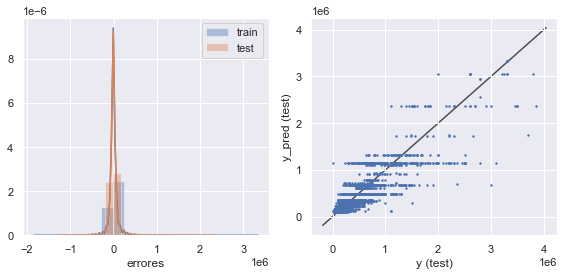

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 20.475
Raíz del error cuadrático medio en Test: 105.200


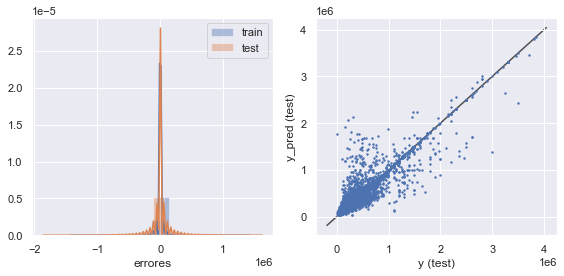

In [108]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
    print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

**Comentarios**

Sumando al feature engeneering la optimización de hiperparámetros con la técnica k-fold validation, obtenemos mejoras significativas para el caso del modelo de Arbol de Decisión y pero un overfiting muy marcado en el caso de Vecinos más cercanos. Mientras que sin la optimización de hiperparámetos obteníamos los resultados inversos.

Arbol de Decisión con optimización de hiperparámetros y Vecinos más cercanos sin optimización de hiperparámetros presentan resultados muy próximos respecto al error cuadrático medio obtenido. Sin embargo, para el primer caso encontramos menor ratio entre el conjunto de entrenamiento y testeo, por lo que sería el modelo elegido.

### 3.5 LGBM Regressor

Probamos un modelo más potente: Light GBM

Light GBM es un marco de mejora de gradientes que utiliza un algoritmo de aprendizaje basado en árboles.
Este algoritmo hace crecer el árbol verticalmente mientras que otro algoritmo hace crecer los árboles horizontalmente, lo que significa que Light GBM crece en forma de hojas de árbol mientras que otro algoritmo crece a nivel. Escogerá la hoja con la máxima pérdida delta para crecer. Cuando se cultiva la misma hoja, el algoritmo de hoja puede reducir más pérdidas que un algoritmo de nivel.

In [109]:
import lightgbm as ltb

In [110]:
model = ltb.LGBMRegressor()

In [111]:
model.fit(X_train, y_train)

LGBMRegressor()

In [112]:
model.get_params(deep=True)

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 84.576
Raíz del error cuadrático medio en Test: 91.480


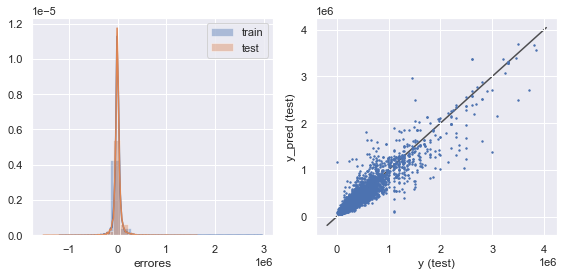

In [113]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
    
print(f'Modelo: {modelos[i]}')
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

**Comentarios**

Los resultados obtenidos con Light GBM son ampliamente superadores que los demás podemos obtenidos en las anteriores iteraciones, tanto en estabilidad como en términos del error cuadrático medio obtenidos.

#### Tuning de hiperparámetros con k fold

In [36]:
from sklearn.model_selection import GridSearchCV

parameters={"max_depth" : [3,4,5,6,7,8, 9,10],
            'num_leaves': [7, 14, 21, 28, 31, 50, 60, 70, 80, 90, 100],
            'n_estimators': [25, 50, 100, 300, 500, 600, 700]
             }

#'learning_rate': [0.1, 0.03, 0.003],
#"max_leaf_nodes":[None,10,20,30,40]

model = ltb.LGBMRegressor(random_state=42)
gs = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=7)
gs.fit(X_train, y_train)

print(gs.best_params_)
print(-gs.best_score_)

{'max_depth': 10, 'n_estimators': 700, 'num_leaves': 60}
8890356924.067863


#### Entrenamos con los nuevos hiperparámetros

In [114]:
model = ltb.LGBMRegressor(max_depth=5, n_estimators=700, num_leaves=60)

In [115]:
model.fit(X_train, y_train)

LGBMRegressor(max_depth=5, n_estimators=700, num_leaves=60)

Raíz del error cuadrático medio en Train: 72.591
Raíz del error cuadrático medio en Test: 87.299


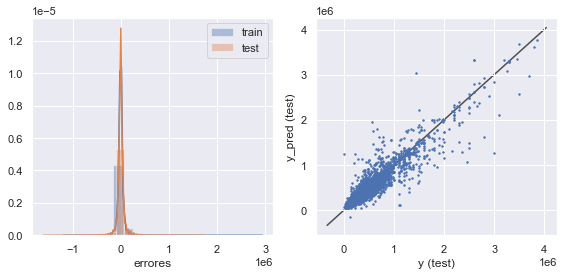

In [116]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
    
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('Raíz del error cuadrático medio en Train:',f'{rmse_train:,.0f}'.replace(',','.'))
print('Raíz del error cuadrático medio en Test:',f'{rmse_test:,.0f}'.replace(',','.'))
        
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

**Comentarios**

Finalmente, aplicando además la optimización de hiperparametros podemos obtener una pequeña mejora de la predicción reduciendo en 10k el error cuadrático medio.

## Conclusiones

A lo largo de las iteraciones fuimos evaluando diferentes modelos y prácticas para obtener el mejor modelo que nos prediga el precio de venta de un inmueble. 

1. En todas las iteraciones nos encontramos que la mayor complicación fue predecir correctamente las propiedades cuyos valores son significativamente altos a la mayoría de las instancias.
2. Para nuestra problemática, Árboles de decisión fue más susceptible al overfiting si no aplicamos optimización de hiperparámetros mientras que Vecinos más cercanos lo fue al aplicar dicha optimización.
3. Feature Engeneering mejoró la performance en todos los modelos aplicados.
4. Con un modelo más potente como Light GBM pudimos obtener el mejor modelo.

In [117]:
name=['rmse_train_b', 'rmse_test_b', 'rmse_train', 'rmse_test']
value = [rmse_train_b, rmse_test_b, rmse_train, rmse_test]
split=['Train', 'Test', 'Train', 'Test']
model=['Regresion Linal','Regresion Linal', 'Arbol de Regresion LGMB', 'Arbol de Regresion LGMB' ]

dicc= {'rmse':name,'value':value,'split':split, 'model':model }
df = pd.DataFrame(dicc)

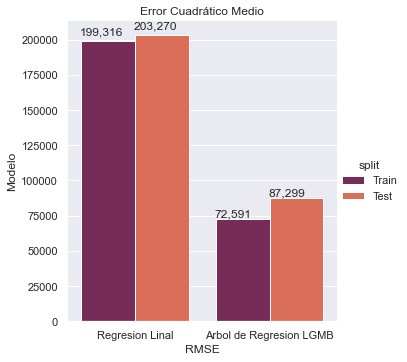

In [118]:

# Draw a nested barplot by species and sex
g = sns.catplot(data=df, kind="bar", x="model", y="value", hue="split",
                ci="sd", palette="rocket")

plt.title('Error Cuadrático Medio')
plt.xlabel('RMSE')
plt.ylabel('Modelo')


ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, p.get_height() * 1.02, '{0:,.0f}'.format(p.get_height()))


In [121]:
train_dif=-(rmse_train/rmse_train_b-1)
test_dif=-(rmse_test/rmse_test_b-1)

print('Mejora obtenida en Train:',f'{train_dif:.2%}'.replace(',','.'))
print('Mejora obtenida en Test:',f'{test_dif:.2%}'.replace(',','.'))

Mejora obtenida en Train: 63.58%
Mejora obtenida en Test: 57.05%


Con el trabajo realizado en el transcurrir de las iteraciones, logramos obtener un promedio de 60% menos de error cuadrático medio respecto a nuestro modelo de benchmark.

Finalmente, queda pendiente de profundizar las siguientes opciones:
1. Dividir el modelo, uno para los valores bajos y medios de precio y otro para los valores altos. Dicho umbral también debe ser analizado.
2. Definir nuestra propia función de costo, para que penalice más una predicción subestimada del precio y menos a una sobrestimación.
3. Definir un error que consideramos esperado y que no queremos que sea considerado como una mala predicción (por ejemplo 10k usd) y que empiece a contar los errores recién a partir de dicho umbral.

### ¡Muchas gracias por haber llegado hasta este punto del trabajo!